# Exercise 7: Causal Modeling

Modified from part 2 of Iain Barr's "notes on causal modeling"

## Setup

In [1]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# New package for working with causal models 
from causalgraphicalmodels import CausalGraphicalModel

%matplotlib inline

## Simulating some stucture

One way we can try and model the world is through the idea of Structural Causal Models, or [Structural Equation Models](https://en.wikipedia.org/wiki/Structural_equation_modeling): that we can model the relationships between different variables is described by functions. 

For example, imagine a system of three variables, $x_{1}, x_{2}, x_{3}$. We could imagine they are related in the following way:

$x_{1} \sim \hbox{Bernoulli}(0.3)$

$x_{2} \sim \hbox{Normal}(x_{1}, 0.1)$

$x_{3} = x_{3}^{2}$

$X_{1}$ and $X_{2}$ are samples from random variables, and $X_{3}$ is a deterministic function of $X_{2}$. 

It is easy to simulate this system in python:

In [ ]:
def f1(): 
    return np.random.binomial(n=1,p=0.3)

def f2(x1):
    return np.random.normal(loc=x1, scale=0.1)
    
def f3(x2):
    return x2 ** 2

x1 = f1()
x2 = f2(x1)
x3 = f3(x2)

print("x1 = {}, x2 = {:.2f}, x3 = {:.2f}".format(x1, x2, x3))

Structure is the description of which variables are functions of which other variables. In the above example, `x1` can only influence `x3` _though_ `x2`, no matter what the actual functions are. 

This way of modeling structure is appealing because it has a natural way to describe interventions: we reach into the system and replace the value of one variable with one we choose. If we replace `x2` with some value `x2_intervention` the system would now be updated according to

```python
x1 = f1()
x2 = x2_intervention
x3 = f3(x2)
```

This has the very measurable consequence that if we intervene on `x2`, `x3` will be independent of `x1`. This wouldn't be the case if the structure had looked something like

```python
x1 = f1()
x2 = f2(x1)
x3 = f3(x2, x1)
```

Here there is no ambiguity about what intervention means, and what the structure of the system is. It might seem too far fetched to assume that _all_ relationships been things we measure can be described this way, but ultimately the justification is the universe is governed by the laws of physics. These functions might be very complicated, stochastic, or unknown, but they exist. 

The question then becomes: what can we say about interventions when we don't know the true functional relationships, only the structure. 

Note: This isn't _entirely_ true. Quantum mechanics has some interesting things to say about causality, and if I get the chance, I'll try and write about them. For most causal inference tasks, we can safely ignore quantum effects.

## Causal Graphical Models

Let us begin with a classical example of a causal system: the sprinker. It is a system of five variable which indicate the conditions on a certain day:

 - $season$: indicates which season it is
 - $rain$: indicates whether it is raining
 - $sprinkler$: indicates whether our sprinkler is on
 - $wet$: indicates whether the group is wet
 - $slippery$: indicates whether the ground is slippery
 
We know that when it rains, the ground will become wet, however the making the ground wet doesn't cause it to rain. This is exactly the kind of direct relationship that could be described by a function. In the absence of this actual function, we are left with a set of variables and directed relationships between then. A natural way to represent this structure is a directed graph, specifically a [Directed Acyclic Graph](https://en.wikipedia.org/wiki/Directed_acyclic_graph). We require the graph to be acyclic to prevent "causal loops".

We can create a causal graphical model of this system by specifying the nodes and edges of this graph:

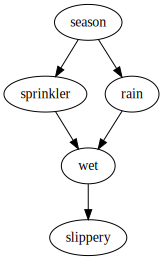

In [3]:
from causalgraphicalmodels import CausalGraphicalModel

sprinkler = CausalGraphicalModel(
    nodes=["season", "rain", "sprinkler", "wet", "slippery"],
    edges=[
        ("season", "rain"), 
        ("season", "sprinkler"), 
        ("rain", "wet"),
        ("sprinkler", "wet"), 
        ("wet", "slippery")
    ]
)

# draw return a graphviz `dot` object, which jupyter can render
sprinkler.draw()

This is a [Probabilistic Graphical Model](https://en.wikipedia.org/wiki/Graphical_model) description of the system (for more information, I recommend this excellent [Coursera Course](https://www.coursera.org/learn/probabilistic-graphical-models) on probabilistic graphical models): a non-parametric model of the structure which generates data.

Describing a system in the way implies that the joint probability distribution over all variables can be factored in the following way:

$p(\mathbf{X}) = \prod_{i}p(X_{i} | \hbox{PA}(X_{i}))$

Where $\hbox{PA}(X_{i})$ is the set of parents of the variable $X_{i}$, with respect to the graph.

We can get the joint probability distribution implied by our causal graphical model using

In [4]:
print(sprinkler.get_distribution())

P(season)P(sprinkler|season)P(rain|season)P(wet|rain,sprinkler)P(slippery|wet)


This factorization of the joint probability distribution in implies certain [conditional independence](https://en.wikipedia.org/wiki/Conditional_independence) relationships between variables. For example, if we know whether or not the ground is wet, then whether or not it is slippery is independent of the season. In the language of probabilistic graphical models, two variables are conditionally independent given other variables if they are [d-separated](https://www.andrew.cmu.edu/user/scheines/tutor/d-sep.html).

I'm not going to go into a full proof of d-separation, but to get some intuition about how it is calculated, consider the skeleton of our DAG (the graph with the same nodes and edges, but no notion of "direction"). Two variables can only be related if there are paths between them, so we can limit our attention to the paths between variables. If there is only a single edge between the variables, they cannot be conditionally independent. 

For paths of three nodes, there are three possible situations, a fork, a chain and a collider, shown below:

Implied conditional Independence Relationship:  [('x1', 'x3', {'x2'})]


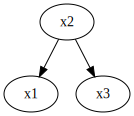

In [5]:
from causalgraphicalmodels.examples import fork, chain, collider

print("Implied conditional Independence Relationship: ", 
      fork.get_all_independence_relationships())
fork.draw()

Implied conditional Independence Relationship:  [('x1', 'x3', {'x2'})]


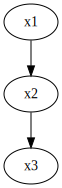

In [6]:
print("Implied conditional Independence Relationship: ", 
      chain.get_all_independence_relationships())
chain.draw()

Implied conditional Independence Relationship:  [('x1', 'x3', set())]


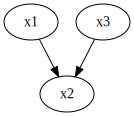

In [7]:
print("Implied conditional Independence Relationship: ", 
      collider.get_all_independence_relationships())
collider.draw()

For the collider, $X_{1}$ and $X_{3}$ are independent, unless $X_{2}$ or any of it's descendants are in the group we condition on. This is sometimes called [Berkson's Paradox](https://en.wikipedia.org/wiki/Berkson%27s_paradox). 

For paths longer then length 3, it turns out we can use the previous results to decide if two nodes are d-separated by examining each three structure along the paths: a path is d-separated if all sets of consecutive 3-nodes are d-separated. 

Consider the following path between $X_{1}$ and $X_{5}$:

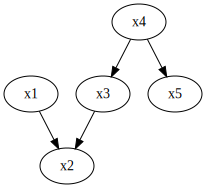

In [8]:
path = CausalGraphicalModel(
    nodes = ["x1", "x2", "x3", "x4", "x5"],
    edges = [("x1", "x2"), ("x3", "x2"), ("x4", "x3"), ("x4", "x5")]
)

path.draw()

In [9]:
print("Are x1 and x5 unconditional independent? {} "
      .format(path.is_d_separated("x1", "x5", {})))

print("Are x1 and x5 conditional independent when conditioning on x2? {} "
      .format(path.is_d_separated("x1", "x5", {"x2"})))

print("Are x1 and x5 conditional independent when conditioning on x2 and x3? {} "
      .format(path.is_d_separated("x1", "x5", {"x2", "x3"})))

Are x1 and x5 unconditional independent? True 
Are x1 and x5 conditional independent when conditioning on x2? False 
Are x1 and x5 conditional independent when conditioning on x2 and x3? True 


We can read off all independence relationships implied by the graph in the sprinkler system using:

In [10]:
sprinkler.get_all_independence_relationships()

[('slippery', 'sprinkler', {'wet'}),
 ('slippery', 'sprinkler', {'rain', 'wet'}),
 ('slippery', 'sprinkler', {'season', 'wet'}),
 ('slippery', 'sprinkler', {'rain', 'season', 'wet'}),
 ('slippery', 'season', {'wet'}),
 ('slippery', 'season', {'sprinkler', 'wet'}),
 ('slippery', 'season', {'rain', 'wet'}),
 ('slippery', 'season', {'rain', 'sprinkler'}),
 ('slippery', 'season', {'rain', 'sprinkler', 'wet'}),
 ('slippery', 'rain', {'wet'}),
 ('slippery', 'rain', {'sprinkler', 'wet'}),
 ('slippery', 'rain', {'season', 'wet'}),
 ('slippery', 'rain', {'season', 'sprinkler', 'wet'}),
 ('wet', 'season', {'rain', 'sprinkler'}),
 ('wet', 'season', {'rain', 'slippery', 'sprinkler'}),
 ('sprinkler', 'rain', {'season'})]

At this point it is worth emphasising that causal graphical models are _non-parametric_: they do not make any assumptions about the functional form of relationships between variables, only that they exist. Because of this the only testable assumption these models make are the conditional independence relationships between the variables. Unfortunately, [testing conditional independence, in the general case, is impossible](https://arxiv.org/pdf/1804.07203.pdf). Combined with the fact that there are [many possible DAGs](http://arantxa.ii.uam.es/~ssantini/writing/notes/s649_dag_counting.pdf) for even a reasonable number of variables, discovering causal structure from observational data alone is very difficult. 

There are still some [interesting approaches](https://arxiv.org/abs/1501.01332) to identifying causal structure, but for these notes, it is best to think of the main use of causal graphical models as a way of explicitly encoding prior knowledge about the structure of a system, and to use this structure combined with observational data to make predictions about the effect of causal interventions.

In [ ]:
# Exercise 1: Build a plausible causal graph involving five variables

## Intervention Graphs

So far, our description of causal graphical models has been the same as those of general [Bayesian Networks](https://en.wikipedia.org/wiki/Bayesian_network). To endow these structures with a notion of causality, we some assumptions about what happens when an intervention occurs. In causal graphical models, this is the notion of "**Stability**" or "**Invariance**" - that when we make an intervention on one variable, the structure of the causal graph and the functional relationships between the remaining variables remain the same.

If the assumption of invariance holds, the effect of an intervention on variable $X$ to remove the edges between the variable and it's parents. We typically denote a node with an intervention with a node with a double outline. 

Imagine that we had the power the control the weather. If use it to make an intervention on the "rain" node of our sprinkler model, we get the following system:

P(season)P(sprinkler|season)P(wet|do(rain),sprinkler)P(slippery|wet)


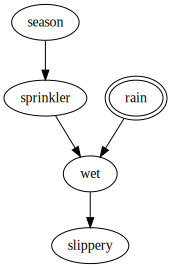

In [12]:
sprinkler_do = sprinkler.do("rain")

print(sprinkler_do.get_distribution())

sprinkler_do.draw()

Because causal graphical models are non-parametric, they cannot tell us _what_ the relationship between two variables are, they only give us an idea _if_ there is a relationship between the two variables through the notion of conditional independence. It does this using the idea of "paths" between variables: if there are no unblocked paths between two variables, they are independent. It also means that if two causal graphical models share the same paths between two variables, the conditional relationship between these two variables are the same. 

For example, in the graph of out sprinkler system, $p(\textrm{slippery}|\textrm{wet})$ is the same whether or not we make an intervention on $rain$, but $p(\textrm{slippery}|\textrm{season})$ is not.

Describing the interventions in the way has some immediate consequences:

- $X$ can only have some causal inference on $Y$ if there is at least one directed path between $X$ and $Y$. 
- If there are _only_ directed paths between $X$ and $Y$, then the the causal influence of $X$ on $Y$ is given by the simply by the conditional distribution $p(Y|X)$. This is because the interventional graph has the same paths between $X$ and $Y$ as the observational distribution.
- If there is a unblocked, but not completely directed path between $X$ and $Y$, it means that both $X$ and $Y$ share a common ancestor. This common ancestor is what is called a [_confounder_](https://en.wikipedia.org/wiki/Confounding), and will mean that if we try to estimate $p(Y|do(X))$ from $p(Y|X)$ of estimates will be biased.
 
None of these results should be too surprising, but causal graphical models give us a way to quantify these understanding.

## Causal Inference with Causal Graphical Models 1: Backdoor adjustment

Now that we have a way of describing how both observational and interventional distributions are generated and how they relate to each other, we can ask under what circumstances it is possible to make causal inferences from a system we only have observational samples from. This problem is often called "Identifiability". 

To be specific, the question is under what circumstances can we estimate

$p(Y|do(X))$

from observational data, given some assumed causal graphical model?

It turns out we can do this via a set of manipulations known as [do-calculus](https://arxiv.org/pdf/1210.4852.pdf), a set of rules which together with the standard [rules of manipulating probability distributions](https://arxiv.org/pdf/1205.4446.pdf) can allow expressions involving distributions conditioned by $do(\dots)$ to be transformed into a form which involves no interventions. 

The backdoor adjustment formula states that under certain circumstances, for a set of variables $W$, we can estimate the the causal influence of $X$ on $Y$ with respect to a causal graphical model using the equation

$p({Y}|{do({X}))} = \sum_{W} p(Y|X, W) p(W)$

The criterion for $W$ to exist is  called the backdoor criterion. Graphically it states that

1. $W$ blocks all backdoor paths between $X$ and $Y$ (all paths with arrows going into $X$)
2. $W$ does not contain any descendants of $X$

Like in the previous section, these criteria are met when $W$ are the parents of $X$, but these aren't the only variables which can be used as an adjustment set. Consider the following graph: 

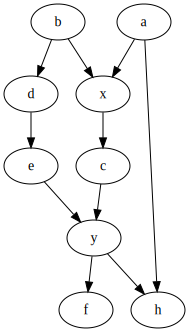

In [19]:
from causalgraphicalmodels.examples import big_csm

example_cgm = big_csm.cgm
example_cgm.draw()

In [17]:
# What are the backdoor paths?
example_cgm.get_all_backdoor_paths("x", "y")

[['x', 'a', 'h', 'y'], ['x', 'b', 'd', 'e', 'y']]

But because $h$ acts as a collider in the first path, it is blocked unless conditioned on. To find a valid adjustment set, we need a set which blocks this path. Any of the variables $B$, $D$, $E$ would work, as well as any combination of the above. We can also include any other variable in this set, as long as it doesn't create new paths. Adding $H$, $F$ or $C$ to the adjustment set would create a new path, making the adjustment set invalid: 

In [20]:
example_cgm.is_valid_backdoor_adjustment_set("x", "y", {"b", "d", "e"})

True

In [21]:
example_cgm.is_valid_backdoor_adjustment_set("x", "y", {"b", "d", "e", "h"})

False

In [22]:
example_cgm.get_all_backdoor_adjustment_sets("x", "y")

frozenset({frozenset({'a', 'd'}),
           frozenset({'b'}),
           frozenset({'b', 'd'}),
           frozenset({'e'}),
           frozenset({'b', 'e'}),
           frozenset({'a', 'b', 'e'}),
           frozenset({'d'}),
           frozenset({'b', 'd', 'e'}),
           frozenset({'a', 'd', 'e'}),
           frozenset({'a', 'b'}),
           frozenset({'d', 'e'}),
           frozenset({'a', 'b', 'd'}),
           frozenset({'a', 'e'}),
           frozenset({'a', 'b', 'd', 'e'})})

## Causal Inference with Causal Graphical Models 1: front-door adjustment


In [ ]:
# Exercise 2: Find all possible front door adjustment sets for the `cgm` model above